# Gray-Level Co-occurance Matrix (GLCM)

## Resources
* https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/
* https://github.com/catboost/tutorials/blob/master/model_analysis/shap_values_tutorial.ipynb
* https://stackoverflow.com/questions/59746304/catboost-classifier-for-class-imbalance
* https://github.com/MartimChaves/glcm_sat_img/blob/main/my_glcm/my_glcm.py
* https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_glcm.html#sphx-glr-auto-examples-features-detection-plot-glcm-py
* https://stackoverflow.com/questions/35551249/implementing-glcm-texture-feature-with-scikit-image-and-python

In [2]:
import skimage 
from skimage.util import img_as_ubyte
from skimage import data
from skimage.feature import graycomatrix, graycoprops
import rasterio as rs
from rasterio.plot import show
import hickle as hkl
import os
import scipy
from scipy import ndimage
import matplotlib.pyplot as plt

In [3]:
scipy.__version__

'1.10.1'

In [4]:
np.__version__

'1.24.2'

In [6]:
skimage.__version__

'0.19.3'

### Option 1 (GLCM and skimage)

In [1]:
def GLCM(outRaster, sizeWindow):
    """
    Run the GLCM textures and append them into one 3D array
    The "ndimage.generic_filter" funtion perform the moving window of size "window"
    Adapted from https://github.com/JavierLopatin/Python-Remote-Sensing-Scripts/blob/master/GLCM.py
    Author: Javier Lopatin
    
    """
    # prepare textures
    def homogeneity_fun(outRaster):
        """
        create Homogeneity using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'homogeneity')[0,0]
        
    def correlation_fun(outRaster):
        """
        create Correlation using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'correlation')[0,0]
    
    def contrast_fun(outRaster):
        """
        create contrast using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'contrast')[0,0]
     
    def  dissimilarity_fun(outRaster):
        """
        create dissimilarity_fun using the GLCM function 
        of Skimage
        """
            
        glcm = graycomatrix(outRaster, [1], [0], symmetric = True, normed = True)
        return graycoprops(glcm, 'dissimilarity')[0,0]

#     outRaster = outRaster*255
#     outRaster = img_as_ubyte(outRaster)
#     if len(outRaster.shape) == 1:
#         print('Reshaping...')
#         outRaster = np.reshape(outRaster, (-1, sizeWindow))


    outRaster = outRaster.astype(np.uint8)
    assert outRaster.dtype == np.uint8, outRaster.dtype
    
    # apply to moving window
    print('Calculating variance')
    
    # np.var returns the variance of the array elements, a measure of the spread of a distribution.
    # doesn't use graycomatrix
    Variance = ndimage.generic_filter(outRaster, np.var, size=sizeWindow)
    print('Calculating contrast')
    Contrast = ndimage.generic_filter(outRaster, contrast_fun, size=sizeWindow)
    print('Calculating dissimilarity')
    Dissimilarity = ndimage.generic_filter(outRaster, dissimilarity_fun, size=sizeWindow)
    print('Calculating correlation')
    Correlation = ndimage.generic_filter(outRaster, correlation_fun, size=sizeWindow)
    print('Calculating homogeneity')
    Homogeneity = ndimage.generic_filter(outRaster, homogeneity_fun, size=sizeWindow)
    print('Calculating entropy')
    Entropy = ndimage.generic_filter(outRaster, entropy, size=sizeWindow)
    
    return np.dstack( (Variance, Contrast, Dissimilarity, Correlation, Homogeneity, Entropy) )

In [ ]:
# raw s2
raw_s2 = hkl.load('../data/train-s2/08154.hkl')
display(raw_s2.shape)


# apply some preprocessing steps to get in somewhat correct version
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
border_x = (s2.shape[0] - 14) // 2
border_y = (s2.shape[1] - 14) // 2
s2 = s2[border_x:-border_x, border_y:-border_y]
s2_slice = s2[...,1]
s2_slice = s2_slice.astype(np.uint8)
display(s2_slice.shape, s2_slice.dtype)

In [ ]:
test = GLCM(s2_slice, 5)

In [ ]:
# pull out a single piece of the function above

def contrast_fun(outRaster):
    """
    create contrast using the GLCM function 
    of Skimage
    """

    glcm = graycomatrix(outRaster, [1], [0], levels=256)
    
    return graycoprops(glcm, 'contrast')[0,0]

contrast = ndimage.generic_filter(s2_slice, contrast_fun, size=5)

In [ ]:
# this is the fully processed s2
img = pp.load_s2('08154')
img = img*255
img = img.astype(np.uint8)
img_slice = img[...,1]
img_slice.shape

In [ ]:
# instead let's try with a slice of this TTC image
img = rs.open('../tmp/tml_preds/479X1129Y_FINAL.tif').read(1)
ttc_slice = img[:14, :14]
print(ttc_slice.shape, ttc_slice.dtype)

In [ ]:
# now using a 2x2 uint8 array - if error then we know it's scipy
test = GLCM(loc1, 5)

### Option 2 (mix of 1 and 3?)

In [18]:
## define a function to run within the moving window

def focal_variance(subarr):
    """Calcualte variance of an array
    """
    return(ndimage.variance(subarr))

# create an arr to process
arr = np.array([[1, 2, 0, 0, 5],
                [5, 3, 0, 4, 5],
                [0, 0, 0, 7, 5],
                [9, 3, 0, 0, 5],
                [9, 3, 0, 0, 5]],dtype=np.uint8)

# define the dimensions of the moving window
# creates a 5x5 array of ones
k = 5
footprint = np.ones((k,k),dtype=np.uint8)

assert arr.dtype == np.uint8
assert len(arr.shape) == 2

# apply moving window across array
ndimage.generic_filter(arr, focal_variance, footprint=footprint)

array([[ 3,  4,  5,  5,  6],
       [ 6,  7,  6,  5,  6],
       [ 9, 11,  8,  5,  6],
       [11, 13,  9,  5,  6],
       [14, 16, 11,  5,  7]], dtype=uint8)

In [31]:
footprint = np.ones((k,k),dtype=np.uint8)
footprint

array([[1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1]], dtype=uint8)

In [24]:
# raw s2
raw_s2 = hkl.load('../data/train-s2/08154.hkl')
s2 = np.delete(raw_s2, -1, -1)
s2 = np.median(s2, axis = 0)
border_x = (s2.shape[0] - 14) // 2
border_y = (s2.shape[1] - 14) // 2
s2 = s2[border_x:-border_x, border_y:-border_y]
s2_slice = s2[...,1]
s2_slice = s2_slice.astype(np.uint8)
display(s2_slice.shape, s2_slice.dtype)

(14, 14)

dtype('uint8')

In [25]:
# now try this with s2
arr = s2_slice
## define a function to run within the moving window

def focal_variance(subarr):
    """Calcualte variance of an array
    """
    return(ndimage.variance(subarr))

# define the dimensions of the moving window
# creates a 5x5 array of ones
k = 5
footprint = np.ones((k,k),dtype=np.uint8) 

assert arr.dtype == np.uint8
assert len(arr.shape) == 2

# apply moving window across array
ndimage.generic_filter(arr, focal_variance, footprint=footprint)

array([[172, 186, 186,  22,  66,  71, 202,  56,  18, 165, 156, 174,  49,
        248],
       [129,  96,  44,  71,  34, 247, 141, 192,  98, 243, 119, 252,  57,
        116],
       [111, 102, 222, 254, 137,   7, 241, 113,  97, 197, 209,  84,  39,
         73],
       [213, 216, 222, 118,  30,  87, 218,  84,  49, 171, 169,  65, 232,
        122],
       [ 24, 171, 175,  63, 162,  59, 145,  57, 193,  72,  97, 100, 134,
        160],
       [254, 132, 135,  94, 165, 209,  73,  48,  52, 241, 172,  89, 232,
         94],
       [  3, 102,   4, 174,  69,  64, 216,  10,  81,  54, 223, 139, 138,
        125],
       [ 40,  95, 136, 252,  99, 243, 154, 142, 109,   0, 211,  81, 114,
        173],
       [ 83, 233, 197, 224, 105,  50,  39, 194, 167, 140, 143,  15, 192,
        142],
       [  2,  70, 143,  62, 186, 133, 191, 120,  43, 107,   1,  96,  10,
        162],
       [ 42, 251, 171,  53,  14,  58, 115,  10,  91, 237, 140,  75,  67,
         64],
       [131, 150, 152,  13, 240, 255,  50, 

### Option 3 (my implementation)

In [7]:
def extract_texture(img):
    
    '''
    Calculates the gray-level co-occurrence matrix (GLCM) and texture
    properties of a GLCM. Input must be 2d
    
    gray-level co-occurrence matrix: a histogram of co-occurring grayscale 
    values at a given offset over an image. The 4D output array is a GLCM
    histogram: levels x levels x number of distances x number of angles.  
    
    gray co-props: Calculates the texture properties of a GLCM. 
    Compute a feature of a GLCM to serve as a compact summary of the matrix. 
    The properties are computed as follows: ‘contrast’, ‘dissimilarity’, 
    ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM’. 
    '''
    img = img.astype(np.uint8)
    
    # Input image must be uint8 and 2d
    assert img.dtype == np.uint8, img.dtype
    
    if len(img.shape) == 1:
        print(img.shape)
        img = np.reshape(img, (-1, 5)) 
    
    # define params
    dist = [1] # indicates the distance to move (1 pixel)
    angl = [0, np.pi/4, np.pi/2, 3*np.pi/4] # indicates which direction to move (up, down, left, right)
    lvl = 256 # indicates number of gray-levels counted (typically 256 for 8-bit image)
    
    glcm = graycomatrix(img, distances=dist, angles=angl, levels=lvl)
    
    properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    
    glcm_props = {}
    for prop in properties:
        gcp = graycoprops(glcm, prop) # can add [0,0] to return...
        glcm_props[prop] = gcp
    
    return glcm, glcm_props

In [32]:
def extract_texture(img):
    
    # define params
    dist = [1] # indicates the distance to move (1 pixel)
    angl = [0, np.pi/4, np.pi/2, 3*np.pi/4] # indicates which direction to move (up, down, left, right)
    lvl = 256 # indicates number of gray-levels counted (typically 256 for 8-bit image)
    
    glcm = graycomatrix(img, distances=dist, angles=angl, levels=lvl)
    
    properties = ['dissimilarity']
    
    glcm_props = {}
    for prop in properties:
        gcp = graycoprops(glcm, prop) # can add [0,0] to return...
        glcm_props[prop] = gcp
    
    return glcm_props

# define the dimensions of the moving window
# creates a 5x5 array of ones
k = 5
footprint = np.ones((k,k),dtype=np.uint8)

assert arr.dtype == np.uint8
assert len(arr.shape) == 2

# apply moving window across array
ndimage.generic_filter(arr, extract_texture, size=5)

SystemError: <built-in function asanyarray> returned a result with an error set

### Option 4 (np.stride_tricks)

In [44]:
# create an arr to process
sample = np.array([[1, 2, 0, 0, 5],
                    [5, 3, 0, 4, 5],
                    [0, 0, 0, 7, 5],
                    [9, 3, 0, 0, 5],
                    [9, 3, 0, 0, 5]],dtype=np.uint8)

In [47]:
# the dimension of the array increases by two and is the size of the window
x = np.lib.stride_tricks.sliding_window_view(arr, (5,5))
x.shape

(1, 1, 5, 5)

In [59]:
sample = np.array([[1, 2, 0, 0, 5],
                    [5, 3, 0, 4, 5],
                    [0, 0, 0, 7, 5],
                    [9, 3, 0, 0, 5],
                    [9, 3, 0, 0, 5]],dtype=np.uint8)

def extract_texture(img):
    
    # define params
    dist = [1] # indicates the distance to move (1 pixel)
    angl = [0, np.pi/4, np.pi/2, 3*np.pi/4] # indicates which direction to move (up, down, left, right)
    lvl = 256 # indicates number of gray-levels counted (typically 256 for 8-bit image)
    
    glcm = graycomatrix(img, distances=dist, angles=angl, levels=lvl)
    
    properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']
    
    glcm_props = {}
    for prop in properties:
        gcp = graycoprops(glcm, prop)[0,0] # can add [0,0] to return...
        glcm_props[prop] = gcp
    
    return glcm_props

def apply_glcm(arr):
    
    # creates the window
    x = np.lib.stride_tricks.sliding_window_view(arr, (5,5))
    
    for window in x:
        glcm = extract_texture(arr)
    
    return glcm
 
contrast = apply_glcm(sample)
contrast

{'dissimilarity': 2.7500000000000004,
 'correlation': 0.12753218710978698,
 'homogeneity': 0.35741310994252173,
 'contrast': 12.649999999999999,
 'ASM': 0.135,
 'energy': 0.3674234614174767}

## Exploring Window Sizes

(618, 610)

dtype('uint8')

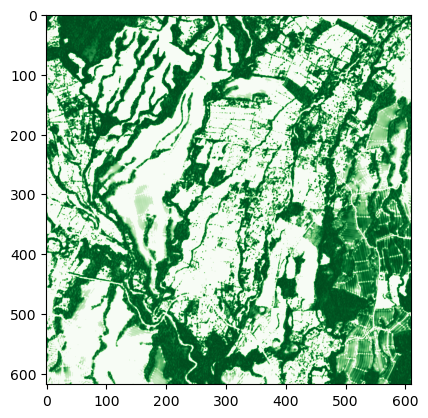

In [8]:
# select an image to work with
img = rs.open('../tmp/tml_preds/479X1129Y_FINAL.tif').read(1)
display(img.shape, img.dtype)
show(img, cmap='Greens');

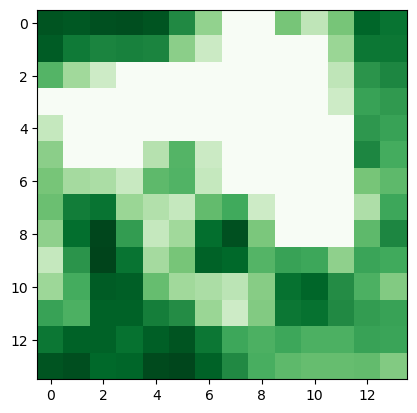

In [10]:
# this is a 14x14 plot
test = img[510:524, 510:524]
show(test, cmap='Greens');

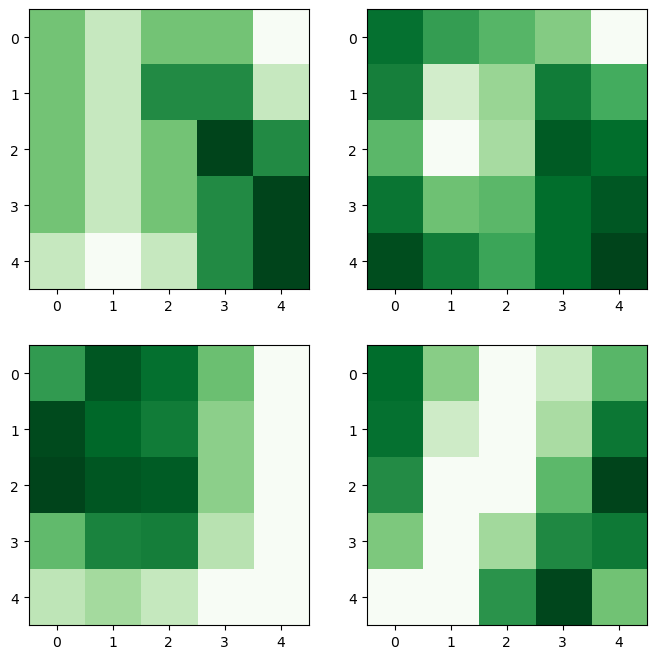

In [11]:
# select 5x5 windows
loc1 = img[500:505, 500:505]
loc2 = img[400:405, 500:505]
loc3 = img[200:205, 500:505]
loc4 = img[100:105, 500:505]
patches = [loc1, loc2, loc3, loc4]

plt.figure(figsize=(8,8))

for i, patch in enumerate(patches):
    ax = plt.subplot(2, 2, i + 1)
    show(patch, cmap='Greens', ax=ax)

In [12]:
# calculate the properties for each 5x5 window
# this uses my simple approach
glcm_patches = {}
for i, patch in enumerate(patches):
    glcm, glcm_props = extract_texture(patch)
    glcm_patches[i] = glcm_props

In [13]:
# will return an array of 5x4 for each 5x5 window
# how many 5x5 windows per 14x14 plot/sample/tile

glcm_patches

{0: {'dissimilarity': array([[1.15  , 0.9375, 0.6   , 1.375 ]]),
  'correlation': array([[ 0.34509979,  0.52915026,  0.71445623, -0.10288561]]),
  'homogeneity': array([[0.475  , 0.55625, 0.71   , 0.4375 ]]),
  'contrast': array([[1.65  , 1.1875, 0.7   , 2.625 ]]),
  'ASM': array([[0.105    , 0.1484375, 0.11     , 0.1015625]]),
  'energy': array([[0.32403703, 0.38527588, 0.33166248, 0.31868872]])},
 1: {'dissimilarity': array([[17.7 , 19.5 , 14.4 , 22.25]]),
  'correlation': array([[0.35371208, 0.06372359, 0.569915  , 0.0379159 ]]),
  'homogeneity': array([[0.01473444, 0.05708533, 0.07016371, 0.07125106]]),
  'contrast': array([[450.2 , 643.  , 334.7 , 745.75]]),
  'ASM': array([[0.05  , 0.0625, 0.05  , 0.0625]]),
  'energy': array([[0.2236068, 0.25     , 0.2236068, 0.25     ]])},
 2: {'dissimilarity': array([[21.1   , 30.25  , 13.8   , 23.3125]]),
  'correlation': array([[0.7704618 , 0.73026185, 0.84984931, 0.59790707]]),
  'homogeneity': array([[0.07633364, 0.0142436 , 0.26934356, 0.